In [1]:
import os
import sys
sys.path.insert(0, os.path.relpath('../../../../..')) 


In [2]:

from recidiviz.calculator.modeling.population_projection.simulations.super_simulation.super_simulation_factory import SuperSimulationFactory
from recidiviz.calculator.modeling.population_projection.simulations.compartment_transitions import CompartmentTransitions
from recidiviz.calculator.modeling.population_projection.spark_policy import SparkPolicy
import pandas as pd
from functools import partial
import yaml

pd.options.display.max_rows = 200

/Users/pacopoler/.local/share/virtualenvs/pulse-data-Jd9N3JcA/lib/python3.7/site-packages/google/cloud/bigquery/table.py:1770: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  create_bqstorage_client=create_bqstorage_client,


outflows_data returned 144 results
transitions_data returned 6 results
total_population_data returned 144 results
initialization time:  1.9367351531982422
simulation_time:  8.26343297958374
initialization time:  2.3221640586853027
simulation_time:  7.468867778778076
initialization time:  2.154810905456543
simulation_time:  7.104219913482666


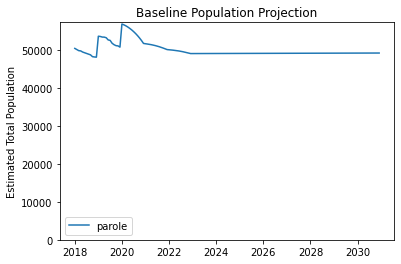

In [3]:
test_sim = SuperSimulationFactory.build_super_simulation('../state/CA/PO_incentives/CA_parole_model_inputs.yaml')
# commented this out once I'm working on the policy but this should be the first thing you run to make sure the simulation is functional
test_sim.simulate_baseline(['parole'])

<AxesSubplot:xlabel='time_step'>

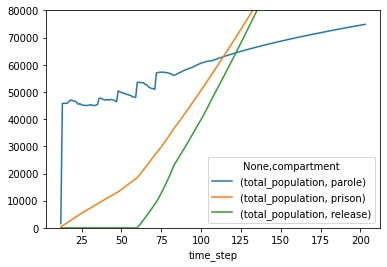

In [20]:
test_sim.simulator.get_population_simulations()['baseline_max'].\
    population_projections.groupby(['time_step', 'compartment']).sum().unstack('compartment').plot(ylim=[0, 80000])


initialization time:  1.5500438213348389
initialization time:  1.758056879043579
simulation_time:  5.691078186035156
simulation_time:  5.702368974685669


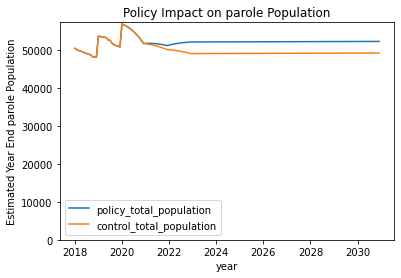

In [4]:
# Policy Option Methods
REVOCATION_REDUCTION = 0.3

def incentivize_completions(retroactive=False):
    return partial(CompartmentTransitions.reallocate_outflow, 
                   reallocation_df=pd.DataFrame({
                       'outflow':['prison'],
                       'affected_fraction': [REVOCATION_REDUCTION],
                       'new_outflow': ['release']
                   }),
                   reallocation_type='*',
                   retroactive=retroactive)


policy_list_non_retroactive = [
    SparkPolicy(policy_fn=incentivize_completions(),
                spark_compartment='parole',
                sub_population={'crime': '1'},
                apply_retroactive=False)
]
    
test_results = test_sim.simulate_policy(policy_list_non_retroactive, 'parole')

In [31]:
simulation_tag = 'CA_PO_incentives_30%'
test_sim.upload_simulation_results_to_bq(simulation_tag)